## 1. 남북간 소득격차

#### -사용 데이터: 가구 특성정보 (+소득정보) 데이터 (환경빅데이터플랫폼)
#### -출처: https://www.bigdata-environment.kr/user/data_market/detail.do?id=8cee0160-2dff-11ea-9713-eb3e5186fb38
#### -주소가 읍면동, 리까지 세분화되어 있음
#### -상세주소를 기준으로 위경도 생성 후, 영동고속도로 기준으로 남북을 나눠줌
#### -태블로를 이용해 지도를 시각화한 후, 영동고속도로 기준 남북 분할
#### -리 단위까지 평균소득이 세분화되어있지만, 총가구수와 총인구수 col은 읍면동단위까지만 세분화되어있어 같은 읍면동이면 차이 x 
#### 따라서 리 단위별 총가구수를 고려하는 것은 큰 의미가 없을 것으로 사료됨

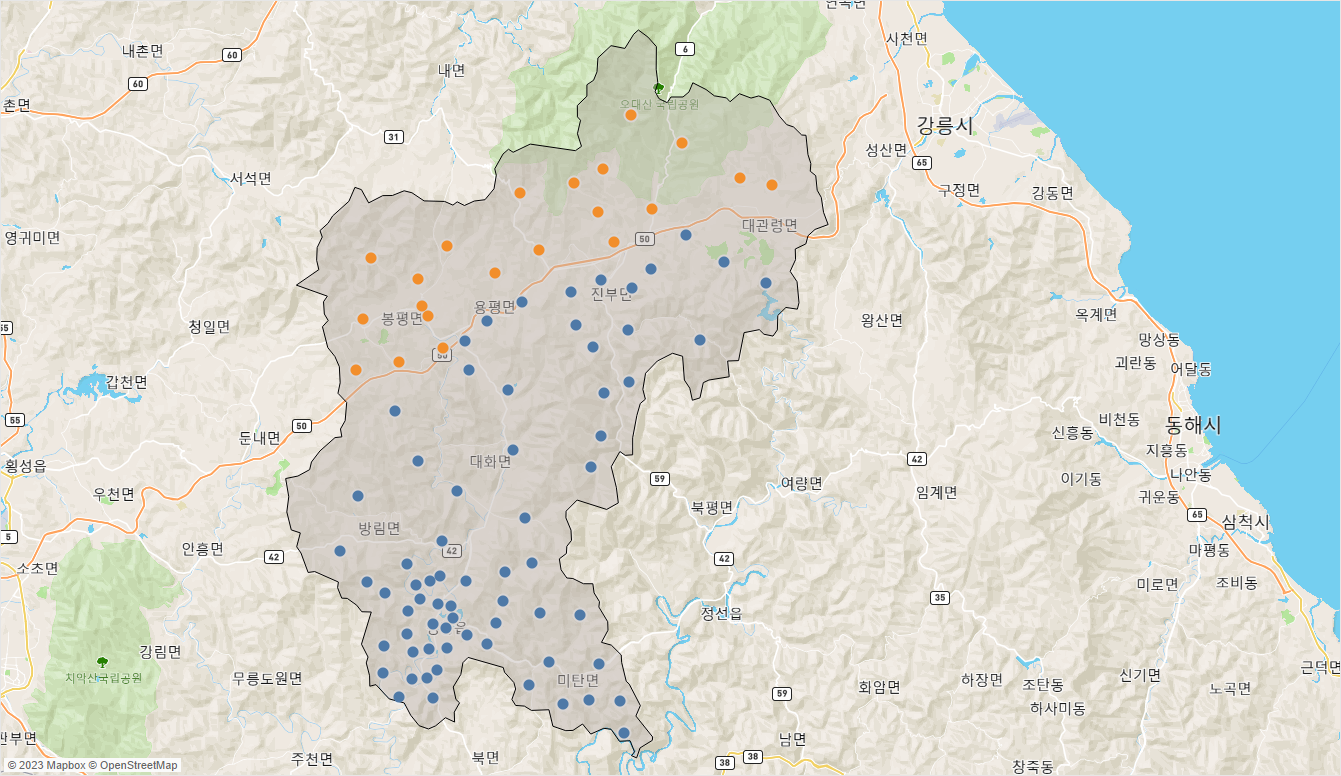

In [ ]:
#한글 깨짐 방지 코드
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import pandas as pd

df1 = pd.read_excel("/content/drive/MyDrive/project_data/평창군데이터_전처리/평창군평균소득(전처리2).xlsx")
df1 = df1.astype({'행정구역':'str'})
df1['리'] = df1['행정구역'].str.split(' ').str[3]

n = df1[df1['남북구분'] == '북부'].iloc[:,6]
s = df1[df1['남북구분'] == '남부'].iloc[:,6]

df1['평균소득금액'] = df1['평균소득금액'].apply(lambda x: x.replace(',',''))
df1 = df1.astype({'평균소득금액':'float'})

In [ ]:
df1['남북구분'].value_counts()

남부    68
북부    21
Name: 남북구분, dtype: int64

#### 남부 지방은 68개 리, 북부 지방은 21개 리 존재

In [ ]:
df1.groupby('남북구분').mean()

,평균소득금액,경도,위도,총가구수,총인구수
남북구분,,,,,
남부,2036.544265,37.441514,128.451972,2897.205882,6360.588235
북부,2283.559524,37.657602,128.475722,2702.238095,5780.904762


##### 남부 지방의 평균 소득은 약 2036.54, 북부 지방의 평균 소득은 약 2283.55
##### 두 지방의 차이가 존재하는지 검정 필요
##### 위에서 총가구수, 총인구수는 평균을 의미함  ex) 남부 총가구수 / 남부의 리 개수 

#### 평균 위경도 시각화 결과

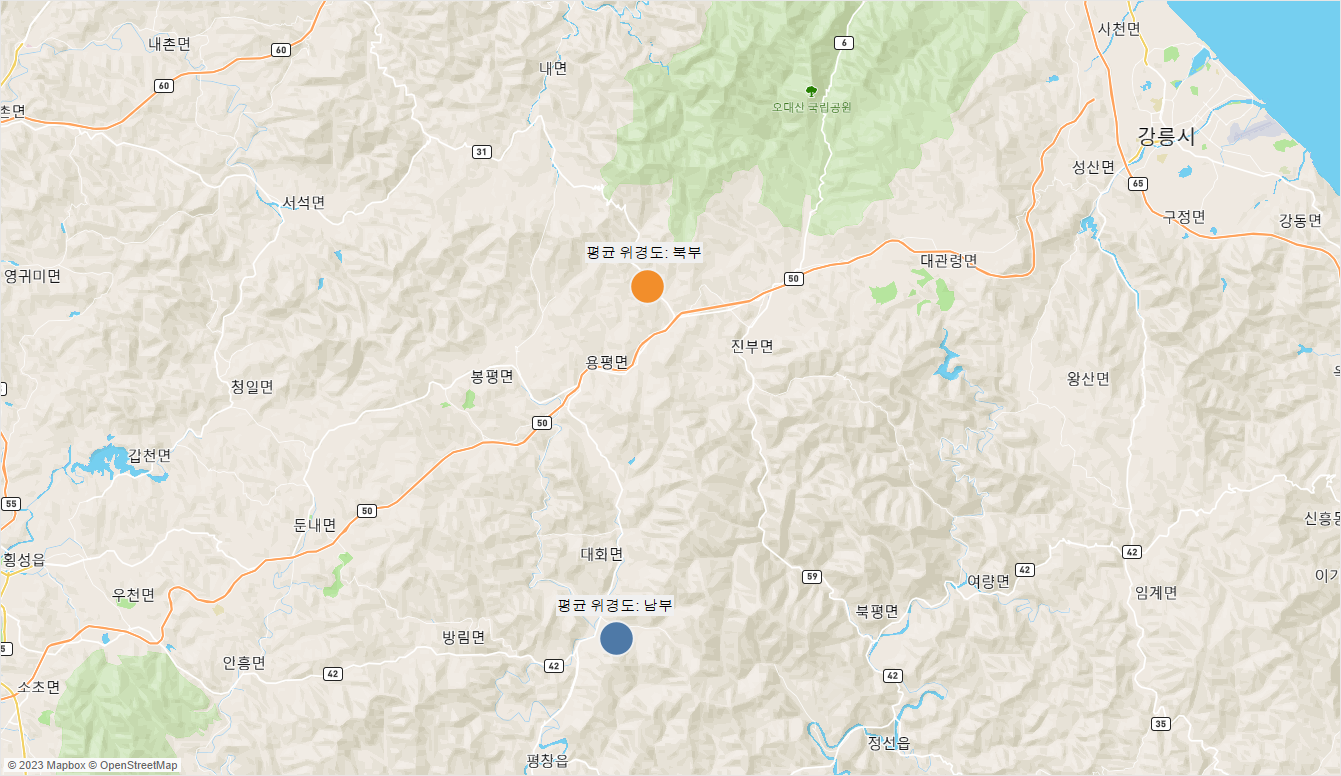

### t검정

In [ ]:
south = df1[df1['남북구분'] =='남부'].reset_index(drop=True)
south = south.sort_values(by='평균소득금액',ascending=False)
south_d = south['평균소득금액']

north = df1[df1['남북구분'] =='북부'].reset_index(drop=True)
north = north.sort_values(by='평균소득금액',ascending=False)
north_d = north['평균소득금액']

##### 남북 소득 격차 시각화

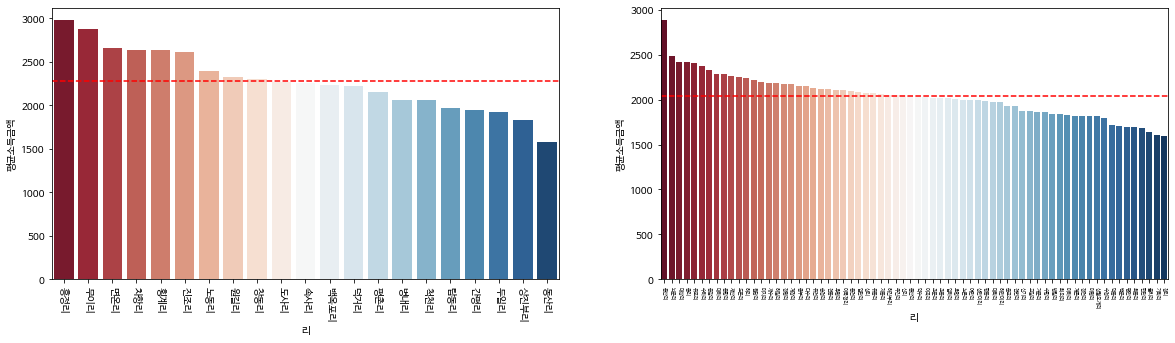

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.barplot(x='리', y='평균소득금액',data=north,palette='RdBu')
plt.xticks(rotation=-90, fontsize=10)
n_mean = north['평균소득금액'].mean()
plt.axhline(n_mean, color='red', linestyle='--')

plt.subplot(1,2,2)
sns.barplot(x='리', y='평균소득금액',data=south,palette='RdBu')
plt.xticks(rotation=-90, fontsize=5)
s_mean = south['평균소득금액'].mean()
plt.axhline(s_mean, color='red', linestyle='--')

plt.show();

In [ ]:
print('북부의 평균 소득:',n_mean)
print('남부의 평균 소득:',s_mean)

북부의 평균 소득: 2283.5595238095243
남부의 평균 소득: 2036.5442647058826


##### 정규성 검정

In [ ]:
import scipy.stats as stats

stats, p_value = stats.shapiro(df1['평균소득금액'])

print('stats:',stats)
print('p-value:',p_value)

if p_value > 0.05:
  print('not reject H0')
else:
  print('reject H0')

stats: 0.9577198624610901
p-value: 0.005510285962373018
reject H0


##### 등분산 검정

In [ ]:
from scipy.stats import levene

stats, p_value = levene(south_d, north_d)

print('stats:',stats)
print('p-value:',p_value)

if p_value > 0.05:
  print('not reject H0')
else:
  print('reject H0')

stats: 5.06189964198239
p-value: 0.02698056646308864
reject H0


##### 정규성, 등분산 가정 위배 -> 비모수 검정

In [ ]:
from scipy.stats import mannwhitneyu

def mann_whitney_u_test(data1, data2):
    stat, p = mannwhitneyu(data1, data2)
    alpha = 0.05
    
    print('statistic:',stat)
    print('p-value:',p)
        
    if p > alpha:
        print("fail to reject H0")
    else:
        print("reject H0")

mann_whitney_u_test(south_d,north_d)      

statistic: 406.0
p-value: 0.0029651630560582885
reject H0


#### 결론: 영동고속도로는 중심으로 남북 지역간의 평균 소득에는 차이가 있다

## 2. 노령화 지수 

#### -사용 데이터: 2022년 시군구/성/연령(5세)별 주민등록연앙인구 (kosis)
#### (연앙인구: 출생률과 사망률을 산출할 때 한 해의 중간인 7월1일을 기준으로 하여 산출한 인구)
#### -출처: https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040M5&conn_path=I3
#### -노령화지수 = 고령인구(65세 이상) ÷ 유소년인구(~14세)×100
#### -노령화 지수 계산을 위해 0~14세 인구를 유소년 인구로, 65세 이상 인구를 고령인구로 병합
#### -데이터 기준은 각 시도의 시군구를 기준으로 하였으며 광역시 이하의 시군구는 제거하였음

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#한글 깨짐 방지 코드
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import pandas as pd
import numpy as np

df2 = pd.read_excel("/content/drive/MyDrive/project_data/평창군데이터_전처리/주민등록인구수.xlsx")

young_df = df2.iloc[:,2:5].sum(axis=1)
old_df = df2.iloc[:,-10:].sum(axis=1)

#노령화지수 = 고령인구(65세 이상) ÷ 유소년인구(~14세)×100

df2['노령화지수'] = old_df / young_df * 100
df2['유소년인구'] = young_df
df2['노년인구'] = old_df

df2.drop(df2.columns[2:-3], axis=1, inplace=True)
df2 = df2.sort_values(by='노령화지수',ascending=False)
df2 = df2.reset_index(drop=True)

df2['노령화지수(로그변환)'] = np.log1p(df2['노령화지수'])
df2.head()

,시도,시군구,노령화지수,유소년인구,노년인구,노령화지수(로그변환)
0,경상북도,군위군,1386.372361,1042.0,14446.0,7.235167
1,경상북도,의성군,1172.763205,2783.0,32638.0,7.067970
2,경상남도,합천군,1079.009861,2484.5,26808.0,6.984725
3,경상북도,청도군,1027.290036,2363.5,24280.0,6.935653
4,전라남도,고흥군,1015.754373,3973.5,40361.0,6.924371


##### '광역시', '특별시'가 아닌 시도의 시군구가 'ㅇㅇ구'인 인덱스 찾아 제거

In [ ]:
no_df = df2[~df2['시도'].str.contains('광역시')]  #물결 표시는 부정의 역할
no_df = no_df[~no_df['시도'].str.contains('특별')]
indexes = no_df[no_df['시군구'].str.endswith('구')]
indexes

,시도,시군구,노령화지수,유소년인구,노년인구,노령화지수(로그변환)
201,경기도,단원구,144.058102,32081.5,46216.0,4.977134


##### 경기도 단원구라는 잘못된 데이터 존재 -> 제거

In [ ]:
df2 = df2[df2['시군구'] != '단원구']

#### (1) 기초통계량

In [ ]:
round(df2.describe())

,노령화지수,유소년인구,노년인구,노령화지수(로그변환)
count,229.0,229.0,229.0,229.0
mean,379.0,26211.0,52855.0,6.0
std,258.0,29312.0,39408.0,1.0
min,71.0,574.0,3252.0,4.0
25%,180.0,4485.0,23886.0,5.0
50%,283.0,15204.0,42088.0,6.0
75%,536.0,36130.0,73087.0,6.0
max,1386.0,156626.0,217703.0,7.0


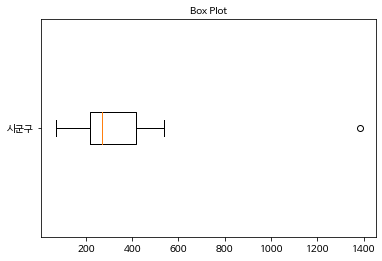

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

plt.boxplot(df2['노령화지수'].describe(),vert=False) 
plt.yticks([1],['시군구'], fontsize=10) 
plt.title('Box Plot',fontsize=10) 
plt.show()

#### (2) 평창군의 위치

In [ ]:
df2[df2['시군구'] == '평창군']

,시도,시군구,노령화지수,유소년인구,노년인구,노령화지수(로그변환)
50,강원도,평창군,589.521368,2925.0,17243.5,6.381006


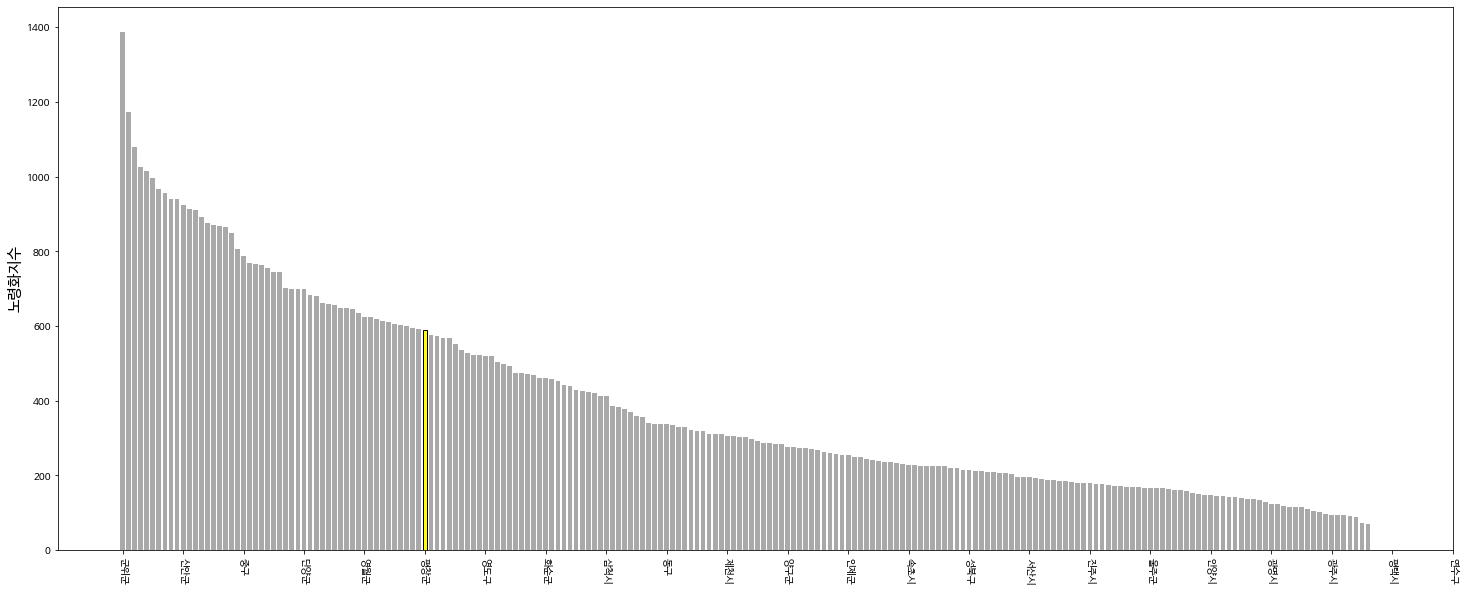

In [ ]:
fig, ax = plt.subplots(figsize=(25,10))
ax.bar(x, y, fc='darkgray')

x_indices = range(0, len(x),10) # display every 10th label
plt.xticks(x_indices, [x[i] for i in x_indices], rotation=-90, fontsize=10)

plt.ylabel('노령화지수', fontsize=15)

bars = ax.patches
bars[50].set_facecolor("yellow")
bars[50].set_edgecolor("k")

#### (3) 노령화 지수 히트맵

##### 노령화지수 (로그변환)을 기준으로 색깔이 붉을수록 노령화지수가 높음

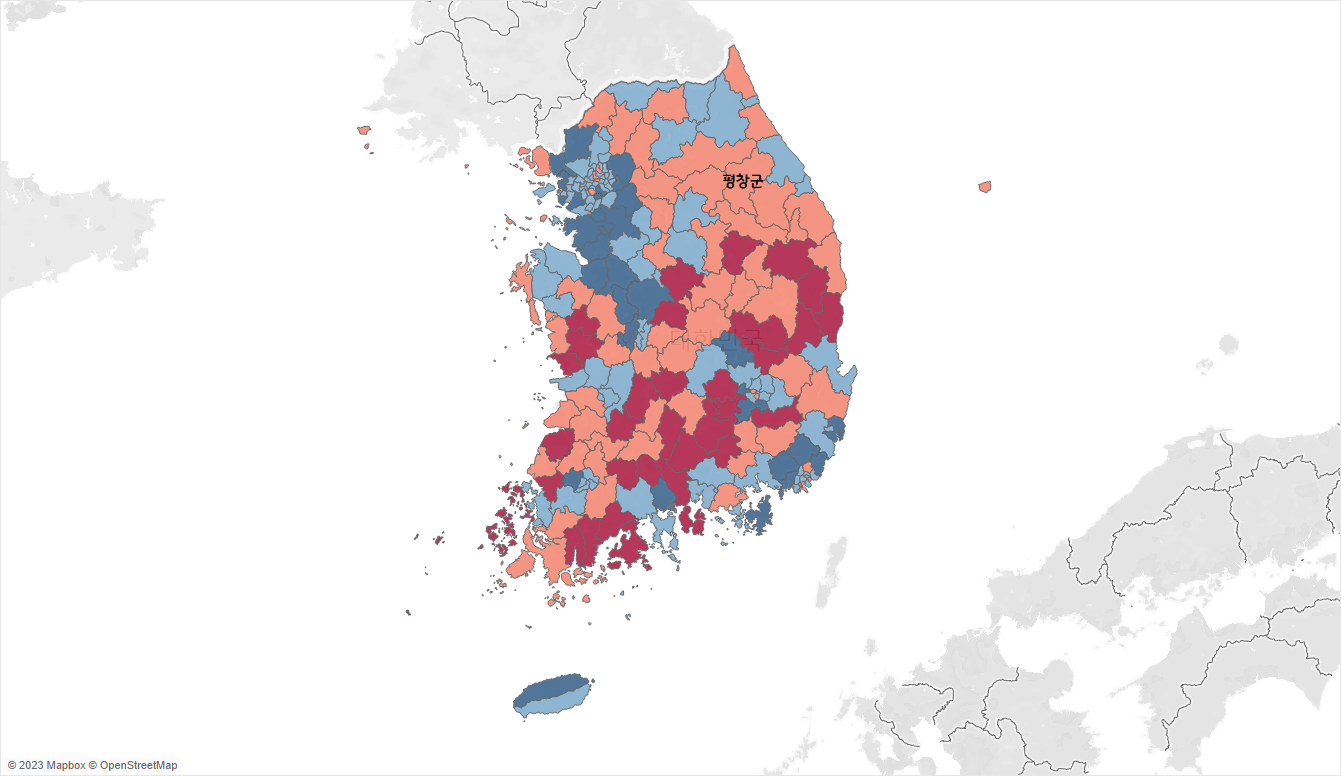

In [ ]:
df2.shape[0]

229

#### 결론: 평창군의 노령화지수는 589.52로 전체 시군구(229개)중 50위에 해당한다. 이는 3사분위수 값을 뛰어넘는 값이며 평균 이상의 노령화지수임을 의미한다.

## 3. 외국인 노동자의 계절적 이동

#### -사용 데이터: 평창군_일별_외국인_생활인구_현황 (2021.11 ~ 2022.11)
#### -출처: 슬통자료
#### -외국인 노동자를 명시적으로 표현하지 못하여 외국인 거주자 데이터로 대체
#### -월별 외국인 노동자의 거주 현황, 계절별 외국인 노동자의 거주 현황을 시각화하여 월, 계절별 차이 확인
#### -대관령면의 경우,

##### 기준년월일 컬럼을 통해 연도, 월, 일, 계절 칼럼생성

In [ ]:
df3 = pd.read_excel('/content/drive/MyDrive/project_data/평창군데이터_전처리/sheet5.xlsx')

df3['기준년도'] = df3['기준년월일'].astype(str).str[:4]
df3['기준월'] = df3['기준년월일'].astype(str).str[4:6]
df3['기준일'] = df3['기준년월일'].astype(str).str[6:]
df3 = df3.drop(columns=['기준년월'])
df3['기준년월일'] = df3['기준년도'] +'-'+df3['기준월']+'-'+df3['기준일']
df3['기준년월일'] = pd.to_datetime(df3['기준년월일'])

In [ ]:
df3 = df3.astype({'기준년도':'int'})
df3 = df3.astype({'기준월':'int'})
df3 = df3.astype({'기준일':'int'})

In [ ]:
df3['계절'] = ''

for i, row in df3.iterrows():
    if 2 < row['기준월'] < 6:
        df3.loc[i, '계절'] = '봄'
    elif 6 <= row['기준월'] < 9:
        df3.loc[i, '계절'] = '여름'
    elif 9 <= row['기준월'] < 12:
        df3.loc[i, '계절'] = '가을'
    else:
        df3.loc[i, '계절'] = '겨울'

In [ ]:
#한글 깨짐 방지 코드
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

#### 2022년의 데이터만을 사용하기 위해 new_df3라는 데이터프레임 생성

In [ ]:
new_df3 = df3[df3['기준년도']==2022]

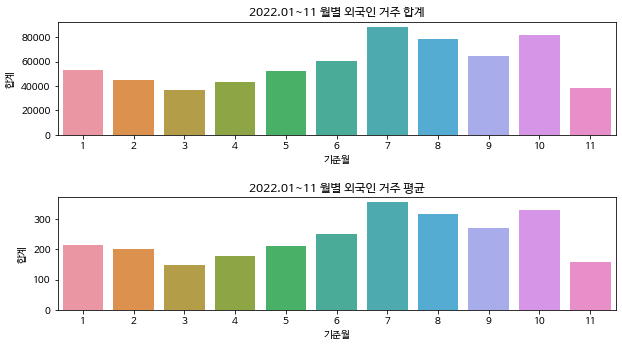

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.4, hspace=0.55)

plt.subplot(2,1,1)
plt.title('2022.01~11 월별 외국인 거주 합계')
sns.barplot(data=new_df3,x='기준월',y='합계',ci=None, estimator=sum)

plt.subplot(2,1,2)
plt.title('2022.01~11 월별 외국인 거주 평균')
sns.barplot(data=new_df3,x='기준월',y='합계',ci=None)
plt.show();

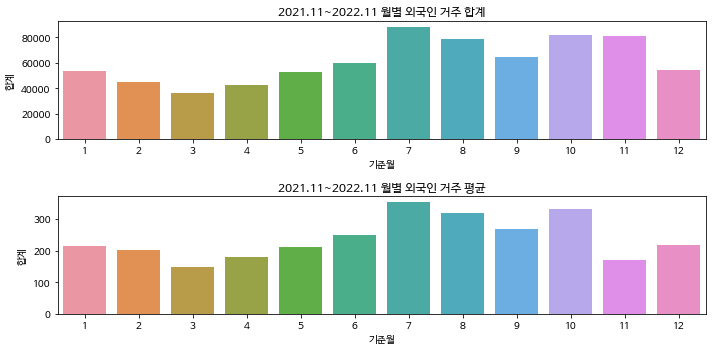

In [ ]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.4, hspace=0.55)

plt.subplot(2,1,1)
plt.title('2021.11~2022.11 월별 외국인 거주 합계')
sns.barplot(data=df3,x='기준월',y='합계',ci=None, estimator=sum)

plt.subplot(2,1,2)
plt.title('2021.11~2022.11 월별 외국인 거주 평균')
sns.barplot(data=df3,x='기준월',y='합계',ci=None)
plt.tight_layout()
plt.show();

##### 2021.11-2022.11과 2022.01-11 두 개의 시각화를 한 이유: 11월과 12월은 21년과 22년 둘다 존재하기 때문에 누적합으로 집계된다
##### 21.11-22.11 월별 외국인 거주 합계 그래프를 보면, 11월이 누적합되어 10월과 비슷한 합계를 보이고 있다 -> 이를 통해 잘못 해석할 여지 존재
##### 평균의 기준 -> sns.barplot() 함수의 기본 집계 방식은 평균(mean). 즉, 막대 그래프의 높이는 각 범주의 관측치에 대한 평균

In [ ]:
df3.groupby(['기준월'])['합계'].sum() / df3.groupby(['기준월'])['합계'].mean()

기준월
1     248.0
2     224.0
3     248.0
4     240.0
5     248.0
6     240.0
7     248.0
8     248.0
9     240.0
10    248.0
11    480.0
12    248.0
Name: 합계, dtype: float64

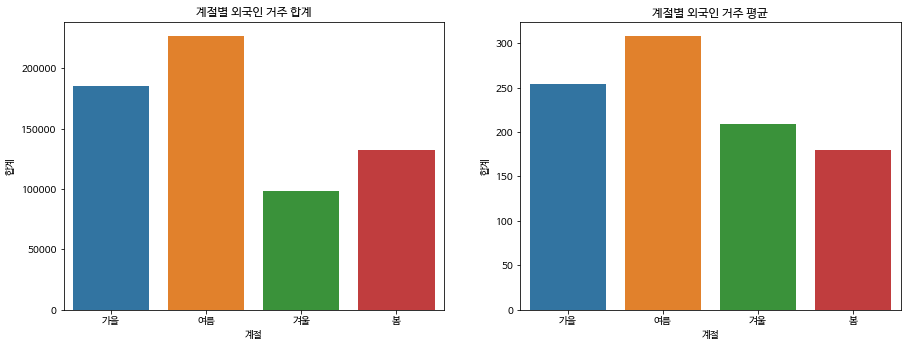

In [ ]:
plt.figure(figsize=(15,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(1,2,1)
plt.title('계절별 외국인 거주 합계')
sns.barplot(data=new_df3,x='계절',y='합계',ci=None, estimator=sum)

plt.subplot(1,2,2)
plt.title('계절별 외국인 거주 평균')
sns.barplot(data=new_df3,x='계절',y='합계',ci=None)
plt.show();

##### 2022년의 자료만을 사용해 계절별 외국인 거주 합계와 평균 시각화
##### 가을과 여름에 많고, 겨울과 봄에 적음

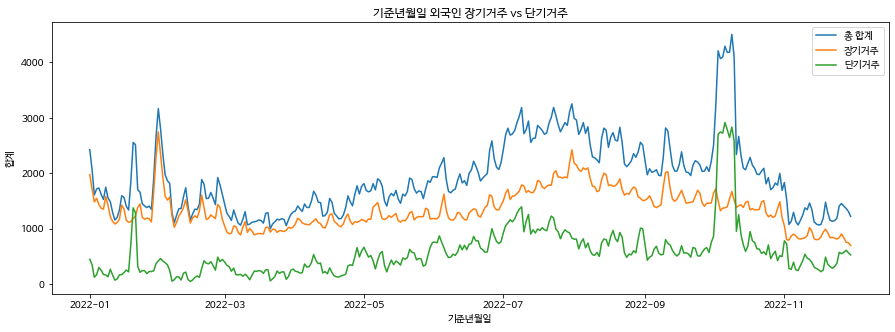

In [ ]:
plt.figure(figsize=(15,5))
plt.title('기준년월일 외국인 장기거주 vs 단기거주')

sns.lineplot(data=new_df3,x='기준년월일',y='합계',ci=None, estimator=sum, label='총 합계')
sns.lineplot(data=new_df3,x='기준년월일',y='장기거주',ci=None, estimator=sum, label='장기거주')
sns.lineplot(data=new_df3,x='기준년월일',y='단기거주',ci=None, estimator=sum, label='단기거주')
plt.show();

##### 22년 2월과 10월에 이상폭 존재

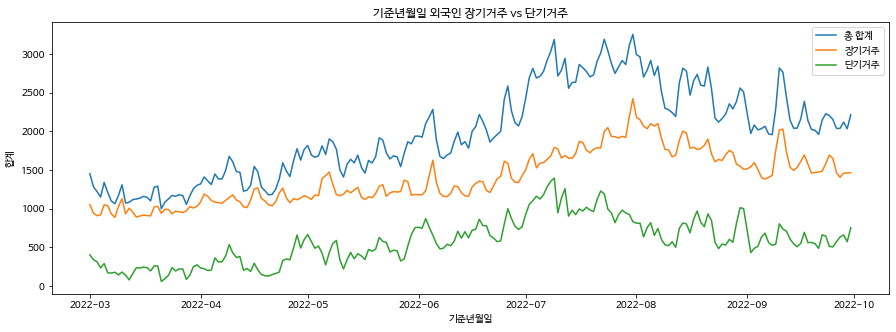

In [ ]:
year =  new_df3['기준년도'] == 2022
month1 = new_df3['기준월']<=9
month2 = new_df3['기준월']>=3
new_df5 = new_df3[year&month1&month2]

plt.figure(figsize=(15,5))
plt.title('기준년월일 외국인 장기거주 vs 단기거주')

sns.lineplot(data=new_df5,x='기준년월일',y='합계',ci=None, estimator=sum, label='총 합계')
sns.lineplot(data=new_df5,x='기준년월일',y='장기거주',ci=None, estimator=sum, label='장기거주')
sns.lineplot(data=new_df5,x='기준년월일',y='단기거주',ci=None, estimator=sum, label='단기거주')
plt.show();

##### 두 이상폭을 제거한 후, 시각화

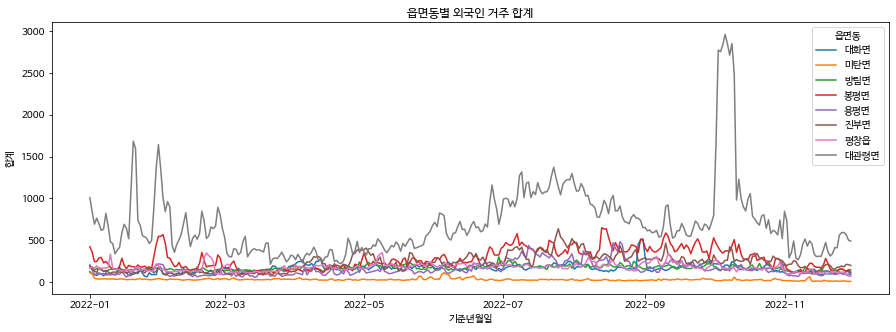

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data=new_df3,x='기준년월일',y='합계', hue='읍면동',ci=None, estimator=sum)
plt.title('읍면동별 외국인 거주 합계')
plt.show();

##### 이상폭을 그리는 시기는 대관령면과 봉편면의 영향이 큰 것으로 판단해 이들을 제외한 읍면동 시각화 

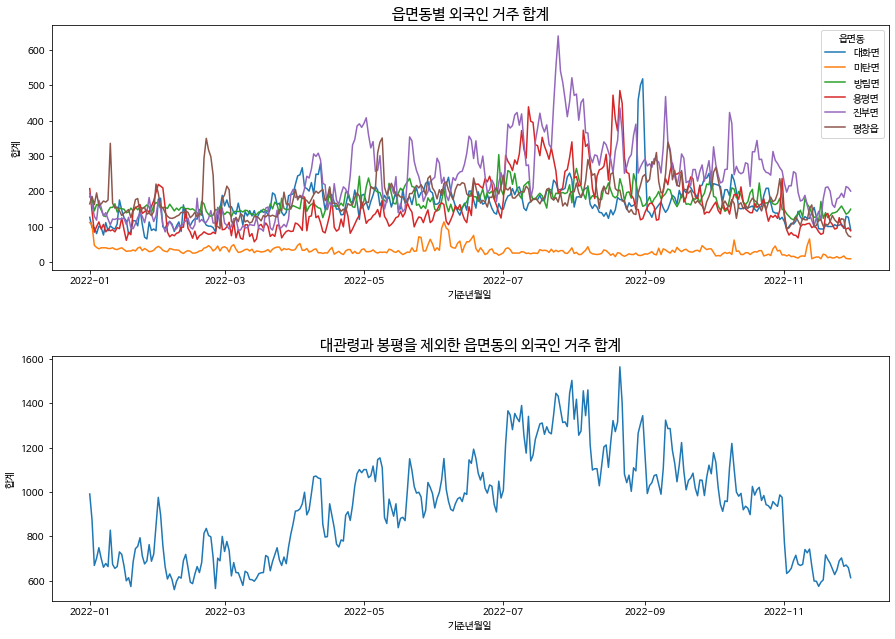

In [ ]:
dae =  new_df3['읍면동'] != '대관령면'
bong = new_df3['읍면동'] != '봉평면'
new_df4 = new_df3[dae&bong]

plt.figure(figsize=(15,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.4, hspace=0.35)

plt.subplot(2,1,1)
sns.lineplot(data=new_df4,x='기준년월일',y='합계', hue='읍면동',ci=None, estimator=sum)
plt.title('읍면동별 외국인 거주 합계',fontsize=15)

plt.subplot(2,1,2)
sns.lineplot(data=new_df4,x='기준년월일',y='합계',ci=None, estimator=sum)
plt.title('대관령과 봉평을 제외한 읍면동의 외국인 거주 합계',fontsize=15)
plt.show();

#### 여기 읍면동별로 계절별 외국인 거주자 수에는 차이가 있다 없다 검정해봐야 할까요?

In [ ]:
group_df = new_df3.groupby('읍면동').sum()
group_df = group_df.iloc[:,:3]
group_df.sort_values(by='합계',ascending=False)

,합계,장기거주,단기거주
읍면동,,,
대관령면,235133,148785,86348
봉평면,93389,62204,31185
진부면,78140,47690,30450
평창읍,59565,49689,9876
방림면,57461,52725,4736
대화면,54660,45085,9575
용평면,53332,35375,17957
미탄면,10945,9612,1333


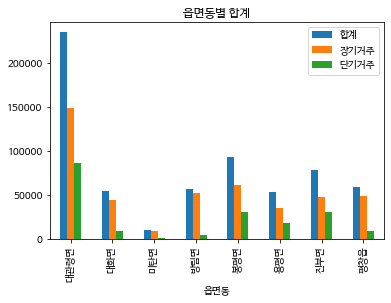

In [ ]:
group_df.plot(kind='bar')
plt.title('읍면동별 합계')
plt.show();

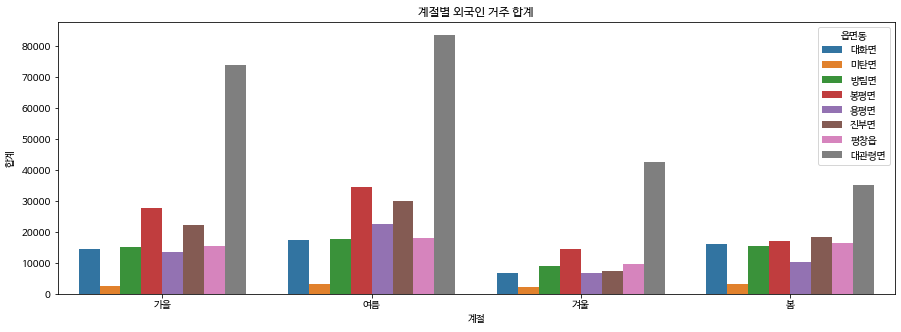

In [ ]:
plt.figure(figsize=(15,5))
plt.title('계절별 외국인 거주 합계')
sns.barplot(data=new_df3,x='계절',y='합계', hue= '읍면동', ci=None, estimator=sum)
plt.show();

#### 결론: 2022년의 데이터를 기준으로 대관령과 봉평을 제외한 읍면동에는 외국인 노동자의 계절적 이동이 존재하는 것으로 보인다. 특히 여름과 가을에 가장 활발하며, 봄과 여름에는 거주자 수가 현저히 줄어들고 있다.

## 4. 실거주지가 원주 혹은 강릉

#### -사용 데이터: 지자체별현황_시간대별_거주인구_방문인구_현황, 지자체별현황_거주지역별_방문인구_숙박현황 
#### -출처: 슬통 자료
#### -무박인구수와 숙박인구수, 그리고 그 합계를 이용하여 평창군에 방문한 인구를 확인
#### -방문인구가 평창군에서 일하는 인구를 대표하는 것은 아님. 다만, ...?


In [ ]:
df4 = pd.read_excel('/content/drive/MyDrive/project_data/평창군데이터_전처리/sheet12.xlsx')
df4 = df4.drop(columns=['거주읍면동'],axis=1)

In [ ]:
grouped = df4.groupby('거주시군구')['합계','무박인구수','숙박인구수'].sum()
group = pd.DataFrame(grouped).sort_values(by='합계',ascending=False)
group.head()

,합계,무박인구수,숙박인구수
거주시군구,,,
평창군,38758,27497,11261
강릉시,20945,15527,5418
원주시,14622,9436,5186
강남구,7811,5639,2172
성남시 분당구,7156,5506,1650


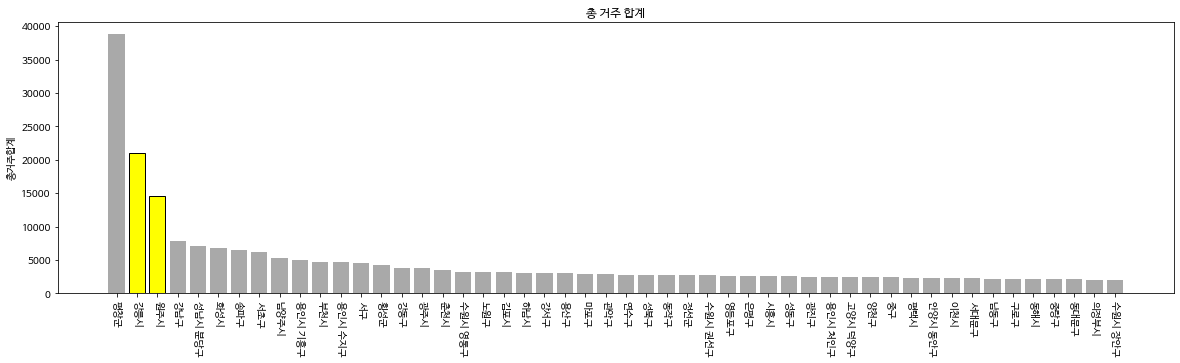

In [ ]:
grouped_top50 = group.head(50)

x = grouped_top50.index.values.copy()
y = grouped_top50.iloc[:, 0].values.copy()

fig, ax = plt.subplots(figsize=(20,5))
ax.bar(x,y,fc='darkgray')
plt.title('총 거주 합계')
plt.xticks(rotation=-90)
plt.ylabel('총거주합계')

bars = ax.patches
bars[1].set_facecolor("yellow")
bars[1].set_edgecolor("k")

bars[2].set_facecolor("yellow")
bars[2].set_edgecolor("k")

##### 평창군에 실거주하는 거주자를 제외하면 강릉시와 원주시에서 평창군을 가장 많이 방문했으며 이는 단순히 여행 목적으로 온건 아닐것임...? -> 뇌피셜

#### 거주시군구가 원주시이거나 강릉시인 거주자들의 데이터

In [ ]:
won = df4['거주시군구'] == '원주시'
gang = df4['거주시군구'] == '강릉시'
wg = df4[won|gang]

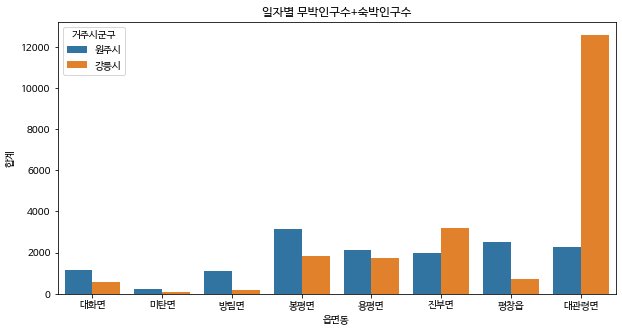

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='읍면동',y='합계',hue='거주시군구',data=wg, ci=None,estimator=sum)
plt.title('일자별 무박인구수+숙박인구수')
plt.show();

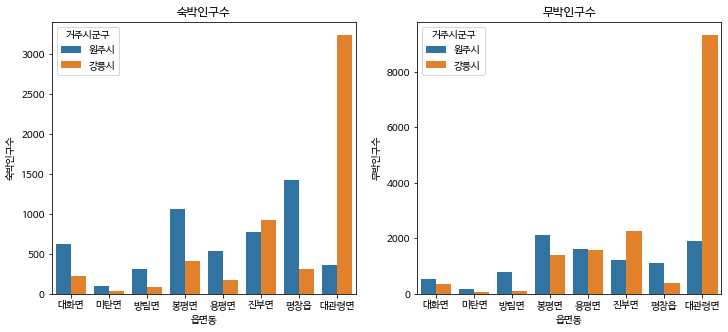

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x='읍면동',y='숙박인구수',hue='거주시군구',data=wg, ci=None, estimator=sum)
plt.title('숙박인구수')

plt.subplot(1,2,2)
sns.barplot(x='읍면동',y='무박인구수',hue='거주시군구',data=wg, ci=None,estimator=sum)
plt.title('무박인구수')
plt.show();

##### 강원시와 원주시의 거주자가 평창군의 어떤 읍면동에 가장 많이 방문했는지 확인
##### -숙박인구수와 방문인구수 모두 강릉시 -> 대관령면 방문이 가장 많음
##### -숙박인구수의 경우, 원주시 -> 평창읍, 봉평면, 진부면 방문이 많음

#### 강릉시 -> 대관령면 방문자들만 모은 데이터 

In [ ]:
dg = wg[wg['거주시군구']=='강릉시']
dg = dg[dg['읍면동']=='대관령면']
dg

,기준년월,시군구,거주시군구,읍면동,합계,무박인구수,숙박인구수
4257,202210,평창군,강릉시,대관령면,140,96,44
4258,202210,평창군,강릉시,대관령면,122,97,25
4259,202210,평창군,강릉시,대관령면,114,80,34
4260,202210,평창군,강릉시,대관령면,92,78,14
4261,202210,평창군,강릉시,대관령면,69,57,12
...,...,...,...,...,...,...,...
83876,202111,평창군,강릉시,대관령면,17,16,1
83886,202111,평창군,강릉시,대관령면,14,12,2
83896,202111,평창군,강릉시,대관령면,14,13,1
84299,202111,평창군,강릉시,대관령면,4,3,1


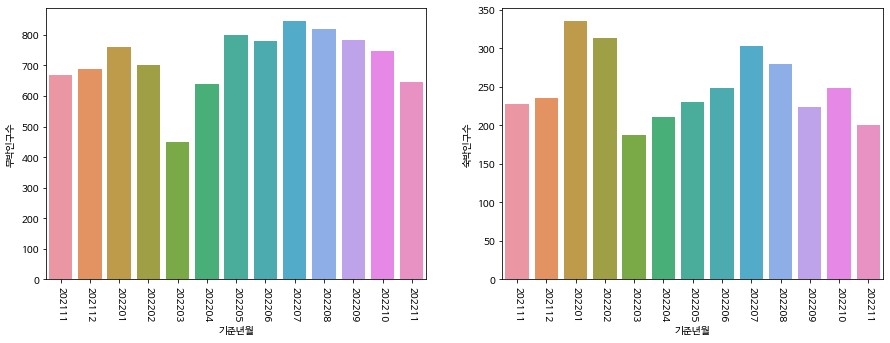

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(x='기준년월',y='무박인구수',data=dg, ci=None,estimator=sum)
plt.xticks(rotation=-90)

plt.subplot(1,2,2)
sns.barplot(x='기준년월',y='숙박인구수',data=dg, ci=None,estimator=sum)
plt.xticks(rotation=-90)

plt.show();